In [114]:
#%matplotlib qt5
%matplotlib inline
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]
np.set_printoptions(precision=4)


Check the time evolution of OTOC's on the light-cone for evolution using dual-unitary circuits.



In [115]:
#Define the unitary gate 

"""
Unitaries defined as going forward in time, with U(a,b,c,d) given by

-0.5 * 1j * np.exp(1j*np.pi/4.*(a-d)*(c-b))*np.exp(-1j*h_1*(a+c)/2.-1j*h_2*(b+d)/2.)

where a,b,c,d \in {1,-1} (in array-notation {1,0})

a   b
|   |
-----
| U |
-----
|   |
c   d
"""

def gate_KIM():
    J = np.pi/4.
    b = np.pi/4.
    h_1 = 0.2
    h_2 = 0.7
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ

    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk", ZZ_exp, K_1, K_2, ZZ_exp)


In [116]:
#Define general dual-unitary gates

def dual_unitary_gate(J, phi):
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1,0], [0, -1]])

    sigma = [X,Y,Z]

    M = 0.25*np.pi*(np.einsum('ac,bd->abcd', X, X)+np.einsum('ac,bd->abcd', Y, Y))-J*np.einsum('ac,bd->abcd', Z, Z)
    V = (expm(-1j*M.reshape(4,4))).reshape([2,2,2,2])
    
    n_u_p = np.random.rand(3)
    n_u_p = n_u_p/(np.linalg.norm(n_u_p))
    theta_u_p = np.random.rand()
    
    n_u_m = np.random.rand(3)
    n_u_m = n_u_m/(np.linalg.norm(n_u_m))
    theta_u_m = np.random.rand()
    
    n_v_p = np.random.rand(3)
    n_v_p = n_v_p/(np.linalg.norm(n_v_p))
    theta_v_p = np.random.rand()
    
    
    n_v_m = np.random.rand(3)
    n_v_m = n_v_m/(np.linalg.norm(n_v_m))
    theta_v_m = np.random.rand()
    
    
    u_plus = np.cos(theta_u_p) * Id + 1j*np.sin(theta_u_p) * np.sum([n_u_p[i]*sigma[i] for i in range(3)],axis=0)
    u_min = np.cos(theta_u_m) * Id + 1j*np.sin(theta_u_m) * np.sum([n_u_m[i]*sigma[i] for i in range(3)],axis=0)
    v_plus = np.cos(theta_v_p) * Id + 1j*np.sin(theta_v_p) * np.sum([n_v_p[i]*sigma[i] for i in range(3)],axis=0)
    v_min = np.cos(theta_v_m) * Id + 1j*np.sin(theta_v_m) * np.sum([n_v_m[i]*sigma[i] for i in range(3)],axis=0)
    
    U = np.exp(1j*phi) * np.einsum( 'ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U)


In [117]:
#Verify unitarity and dual unitarity

#U = gate_KIM()
U = dual_unitary_gate(2.,0.)

q = U.shape[0]

IdId = np.einsum("ac,bd->abcd", np.identity(q), np.identity(q))

print("Shape of U:", U.shape) #In love with the shape of U

#Check unitarity of U
print("Check unitarity: U * U^{\dag}-1 = ", np.linalg.norm(np.einsum('abcd,efcd -> abef', U, np.conj(U))-IdId))
print("Check unitarity: U^{\dag} * U-1 = ", np.linalg.norm(np.einsum('cdab,cdef -> abef', np.conj(U), U)-IdId))

#Check dual unitarity of U
print("Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 = ",
      np.linalg.norm(np.einsum('fbea,fdec->abcd',np.conj(U),U)-IdId))
print("Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 = ",
      np.linalg.norm(np.einsum('bfae,dfce->abcd',np.conj(U),U)-IdId))

Shape of U: (2, 2, 2, 2)
Check unitarity: U * U^{\dag}-1 =  6.363811260456286e-16
Check unitarity: U^{\dag} * U-1 =  6.271163326240782e-16
Check dual unitarity: tilde{U} * tilde{U}^{\dag} - 1 =  6.794449261490003e-16
Check dual unitarity: tilde{U}^{\dag} * tilde{U} - 1 =  7.153878469295175e-16


In [118]:
#Represent unitaries as matrices rather than tensors

def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])


On the light-cone the OTOC can be expressed as 

\begin{equation}
1 - \mathrm{Tr} \left[ a_x^{\alpha} U^{\dagger} a_y^{\beta} U a_x^{\alpha} U^{\dagger} a_y^{\beta} U \right] / \mathrm{Tr}\left[1\right] = 1 - \frac{1}{q}\left \langle  L  \vert T^t\vert R\right \rangle
\end{equation}

with $T$ the column transfer matrix and $|R\rangle$ and $\langle L |$ boundary conditions depending on both the (parity of the) position and the type of operator $\alpha, \beta$.


In [119]:
def col_transfer_mat(U):
    #Construct column transfer matrix given a unitary
    return np.einsum('amqe,bmnf,cpnj,dpqk->abcdefjk',np.conj(U),U,np.conj(U),U) / q

def right_boundary(op):
    return np.einsum('ad,bc->abcd',op,op)

def left_boundary(op):
    return np.einsum('ab,cd->abcd',op,op)

def contract_mv(mat,vec):
    return np.einsum('abcdefgh,efgh -> abcd',mat,vec)

def contract_vv(vec_1,vec_2):
    return np.einsum('abcd,abcd',vec_1,vec_2)

We can explicitly check the time evolution for $\sigma_x$ and $\sigma_z$ ($\sigma_y$ is als possible, but requires me to be more careful with complex conjugation).


In [120]:
T = col_transfer_mat(U)

Id = np.array([[1,0],[0,1]])
X = np.array([[0,1], [1, 0]])
Z = np.array([[1,0], [0, -1]])

t_range = np.arange(10)

R_Id = right_boundary(Id)
L_Id = left_boundary(Id)

def evol(U, op_L, op_R, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    T = col_transfer_mat(U)
    R = right_boundary(op_R)
    L = left_boundary(op_L)
    
    vec_t = R
    for t_i in t_range:
        OTOC_range[t_i] = 1. - contract_vv(L,vec_t) / q
        vec_new  = contract_mv(T,vec_t)
        vec_t = vec_new
    return [t_range,OTOC_range]

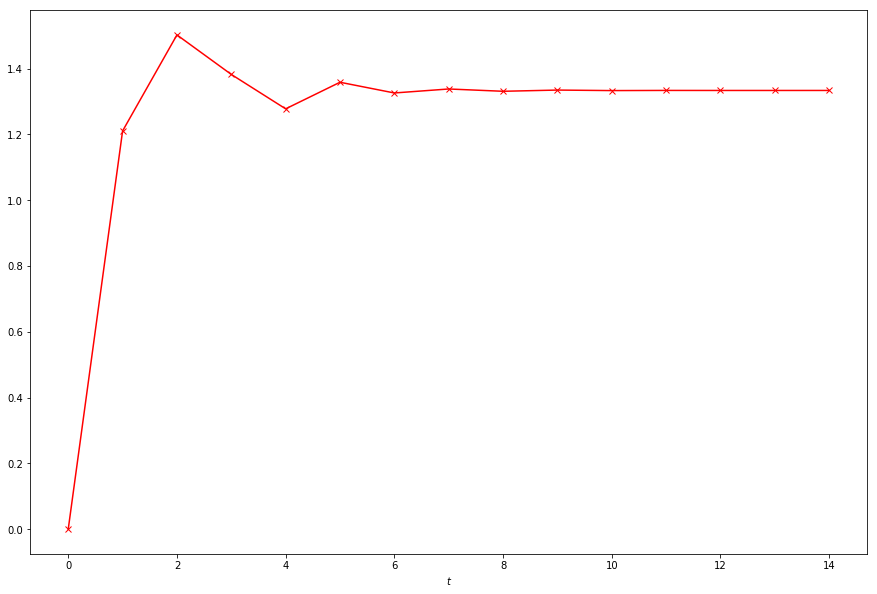

In [121]:
n_t = 15
plt.figure()
[t_range, OTOC_range] = evol(U, X, X, n_t)
plt.plot(t_range,OTOC_range.real,'rx-')
plt.xlabel(r'$t$')
plt.show()

The long-time behaviour is fully determined by the eigenvectors with unit eigenvalue, and two/three of these can be explicitly constructed (representing unitarity, dual-unitarity, and an additional restriction similar to the action on a product state for the KIM).

In [122]:
[E,_] = np.linalg.eig(tensor_to_matrix(T))
print("Eigenvalues of T: \n\n", np.sort(E))


#Check eigenstates
print("\nCheck known eigenstates:\n")
e_1 = 1./q * np.einsum('abcdeffe->abcd',T)
#print("<e_1 | e_1>")
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_1)-e_1))

e_2 = 1./np.sqrt(q**2-1.)* ( np.einsum('abcdeeff->abcd',T) - 1./q * np.einsum('abcdeffe->abcd',T))
#print('T |e_2> - |e_2>')
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_2)-e_2))

e_3 = (np.einsum('abcdeeee -> abcd',T) - e_1 - np.sqrt((q-1.)/(q+1.)) * e_2) * np.sqrt((q+1)/(q-1)) / np.sqrt(q)
#print('T |e_3> - |e_3>')
#print(np.linalg.norm(np.einsum('abcdefgh,efgh -> abcd',T,e_3)-e_3))

eig_vecs = [e_1,e_2,e_3]

for eig_vec in eig_vecs:
    print(" || (T-1) | e_i > || = ", np.linalg.norm(contract_mv(T,eig_vec)-eig_vec))

#Check orthonormality
ov = np.zeros([3,3], dtype=complex)
for i, vec_i in enumerate(eig_vecs):
    for j, vec_j in enumerate(eig_vecs):
        ov[i,j] = contract_vv(vec_i,vec_j)
        
print("\nCheck orthonormality of known eigenstates:\n")
print(ov)

Eigenvalues of T: 

 [-0.4772-1.2944e-01j -0.4772+1.2944e-01j -0.071 -3.4097e-01j
 -0.071 +3.4097e-01j  0.0063-8.3819e-01j  0.0063+8.3819e-01j
  0.0063-8.3819e-01j  0.0063+8.3819e-01j  0.0063-8.3819e-01j
  0.0063+8.3819e-01j  0.4088+2.5731e-16j  0.8152+1.2040e-16j
  0.8152+8.7809e-17j  0.8152-3.3307e-16j  1.    -1.3878e-17j
  1.    -1.2025e-16j]

Check known eigenstates:

 || (T-1) | e_i > || =  4.338439575122018e-16
 || (T-1) | e_i > || =  3.4328700690821445e-16
 || (T-1) | e_i > || =  1.2840755269327861

Check orthonormality of known eigenstates:

[[ 1.0000e+00+1.8689e-17j  2.7756e-17-2.5273e-18j -6.9389e-17+1.6274e-17j]
 [ 2.7756e-17-2.5273e-18j  1.0000e+00+2.6337e-18j -5.5511e-17+4.3094e-18j]
 [-6.9389e-17+1.6274e-17j -5.5511e-17+4.3094e-18j  1.0802e-02+2.5641e-17j]]


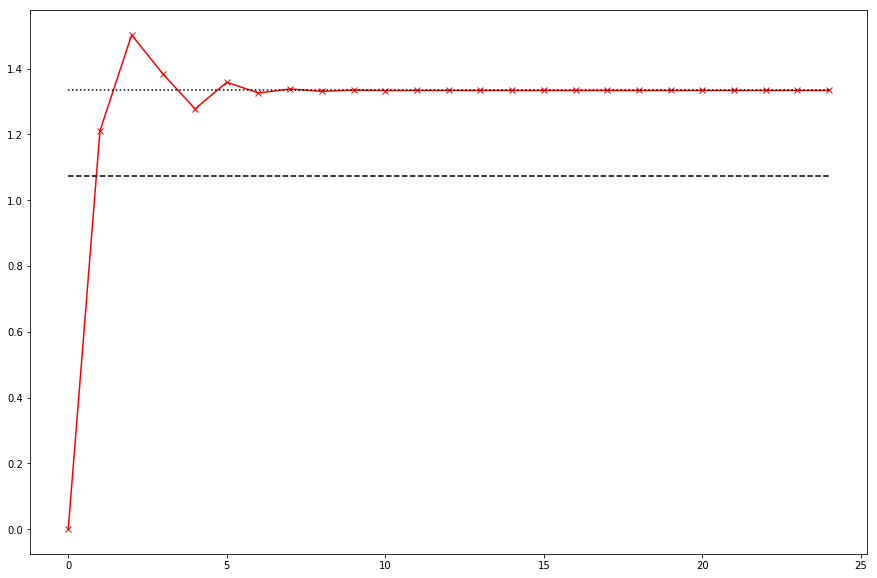

Final OTOC value:  (1.3333333369010782+1.165278445661012e-17j)
q^2/(q^2-1) =  1.3333333333333333


In [124]:
op_L, op_R = X, X
n_t = 25

[t_range, OTOC_range] = evol(U, op_L, op_R, n_t)
OTOC_f = 1. - np.sum([contract_vv(left_boundary(op_L),eig_vec)*contract_vv(eig_vec,right_boundary(op_R)) for eig_vec in eig_vecs])/q

plt.figure()
plt.plot(t_range,OTOC_range.real,'rx-')
plt.plot(t_range,[OTOC_f.real]*n_t,'k--')
plt.plot(t_range,[q**2 / (q**2-1.)]*n_t,'k:')
plt.show()

print("Final OTOC value: ", OTOC_range[-1])
print("q^2/(q^2-1) = ", q**2 / (q**2-1.))

The final values can be explicitly calculated for both the KIM and the more general dual-unitary circuit. For the KIM we get 1 for xx, 0 for zz, and 2 for zx (the difference follows entirely from the third eigenvalue, which depends explicitly on the boundary operators). The only non-trivial behaviour seems to be for xx. For the more general dual-unitary circuit we get q^2/(q^2-1) for all possible operators.